In [3]:
import pandas as pd

# Load the spool file
with open("telehealth_spool_final.txt", "r") as f:
    lines = f.readlines()

section = None
data = {
    "race": [],
    "urbanization": [],
    "education": [],
    "urbanization_combo": []
}
values = {
    "race": [],
    "urbanization": [],
    "education": [],
    "urbanization_avg": [],
    "urbanization_bene": []
}

for i in range(len(lines)):
    line = lines[i].strip()

    if "RACE" in line and "URBANIZATION" not in line:
        section = "race"
        continue
    elif "URBANIZATION" in line and "TOTAL_BENE" not in "".join(lines[i+1:i+3]):
        section = "urbanization"
        continue
    elif "EDUCATION" in line:
        section = "education"
        continue
    elif "URBANIZATION" in line and "TOTAL_BENE" in "".join(lines[i+1:i+3]):
        section = "urbanization_combo"
        continue
    
    if not line or set(line).issubset("-") or "AVG_TELEHEALTH_USAGE" in line:
        continue

    if section in {"race", "urbanization", "education"}:
        if i + 1 < len(lines):
            label = line
            value_line = lines[i + 1].strip()
            try:
                value = float(value_line)
                data[section].append(label)
                values[section].append(value)
                i += 1
            except ValueError:
                continue
    
    if section == "urbanization_combo":
        if i + 1 < len(lines):
            label = line
            value_line = lines[i + 1].strip()
            parts = value_line.split()
            if len(parts) == 2:
                try:
                    avg = float(parts[0])
                    bene = int(parts[1])
                    data["urbanization_combo"].append(label)
                    values["urbanization_avg"].append(avg)
                    values["urbanization_bene"].append(bene)
                    i += 1
                except ValueError:
                    continue

race_df = pd.DataFrame({"race": data["race"], "avg_telehealth_usage": values["race"]})
urban_df = pd.DataFrame({"urbanization": data["urbanization"], "avg_telehealth_usage": values["urbanization"]})
edu_df = pd.DataFrame({"education": data["education"], "avg_telehealth_usage": values["education"]})
urban_combo_df = pd.DataFrame({
    "urbanization": data["urbanization_combo"],
    "avg_telehealth_usage": values["urbanization_avg"],
    "total_bene_telehealth": values["urbanization_bene"]
})

# Display outputs
print("Race:\n", race_df, "\n")
print("Urbanization:\n", urban_df, "\n")
print("Education:\n", edu_df, "\n")
print("Urbanization + Medicare:\n", urban_combo_df)


Race:
                  race  avg_telehealth_usage
0  Black non-Hispanic             27.733333
1            Hispanic             22.877778
2  Other non-Hispanic             23.846667
3  White non-Hispanic             24.255556 

Urbanization:
   urbanization  avg_telehealth_usage
0        Urban             24.811111
1        Rural             21.166667
2      Unknown             24.687037 

Education:
             education  avg_telehealth_usage
0             college             25.311111
1  highschool or less             22.388889
2   bachelor or above             25.555556
3             Unknown             24.168889 

Urbanization + Medicare:
   urbanization  avg_telehealth_usage  total_bene_telehealth
0        Urban             22.433333              216895932
1      Unknown             22.400000                      0
2        Rural             18.566667               48255942


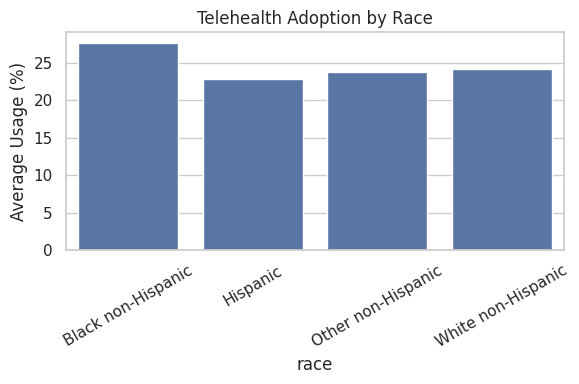

                 race  avg_telehealth_usage
0  Black non-Hispanic             27.733333
1            Hispanic             22.877778
2  Other non-Hispanic             23.846667
3  White non-Hispanic             24.255556


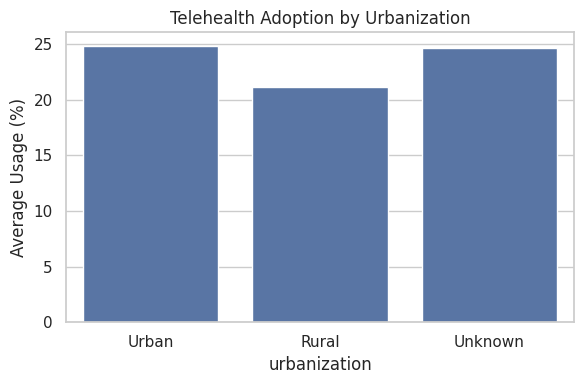

  urbanization  avg_telehealth_usage
0        Urban             24.811111
1        Rural             21.166667
2      Unknown             24.687037


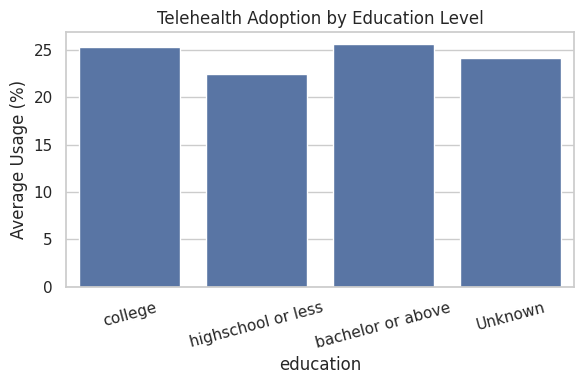

            education  avg_telehealth_usage
0             college             25.311111
1  highschool or less             22.388889
2   bachelor or above             25.555556
3             Unknown             24.168889


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind


# Plot 1: Race
plt.figure(figsize=(6, 4))
sns.barplot(x="race", y="avg_telehealth_usage", data=race_df)
plt.title("Telehealth Adoption by Race")
plt.ylabel("Average Usage (%)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

print(race_df)


# Plot 2: Urbanization
plt.figure(figsize=(6, 4))
sns.barplot(x="urbanization", y="avg_telehealth_usage", data=urban_df)
plt.title("Telehealth Adoption by Urbanization")
plt.ylabel("Average Usage (%)")
plt.tight_layout()
plt.show()

print(urban_df)

# Plot 3: Education
plt.figure(figsize=(6, 4))
sns.barplot(x="education", y="avg_telehealth_usage", data=edu_df)
plt.title("Telehealth Adoption by Education Level")
plt.ylabel("Average Usage (%)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print(edu_df)


In [5]:
import pandas as pd
from scipy.stats import norm


df = pd.read_csv("Access_and_telemedicine_use_COVID19_CLEAN.csv")

# Filter the relevant indicator (actual telehealth use)
df_filtered = df[
    (df["indicator"] == "Scheduled one or more telemedicine appointments") &
    (df["race"].notna()) &
    (df["percent_yes"].notna()) &
    (df["standarderror_yes"].notna())
]

# Group by race: average percent & standard error
grouped = df_filtered.groupby("race").agg({
    "percent_yes": "mean",
    "standarderror_yes": "mean"
}).reset_index()

# 2020 US Census: Proportion of population by race
population_props = {
    "White non-Hispanic": 0.616,
    "Hispanic": 0.189,
    "Black non-Hispanic": 0.124,
    "Other non-Hispanic": 0.071
}
grouped["pop_proportion"] = grouped["race"].map(population_props)

# Run z-tests
results = []
for _, row in grouped.iterrows():
    if pd.notnull(row["pop_proportion"]):
        p_hat = row["percent_yes"] / 100
        p_0 = row["pop_proportion"]
        se = row["standarderror_yes"] / 100
        z = (p_hat - p_0) / se
        p_value = 2 * (1 - norm.cdf(abs(z)))
        results.append({
            "race": row["race"],
            "telehealth_rate (%)": round(p_hat * 100, 2),
            "population_share (%)": round(p_0 * 100, 2),
            "standard_error (%)": round(se * 100, 3),
            "z_score": round(z, 3),
            "p_value": round(p_value, 4),
            "significant (α=0.05)": p_value < 0.05
        })

# Output results
result_df = pd.DataFrame(results)
print(result_df.to_string(index=False))

              race  telehealth_rate (%)  population_share (%)  standard_error (%)  z_score  p_value  significant (α=0.05)
Black non-Hispanic                26.00                  12.4               2.567    5.299   0.0000                  True
          Hispanic                20.27                  18.9               2.200    0.621   0.5345                 False
Other non-Hispanic                18.63                   7.1               2.467    4.676   0.0000                  True
White non-Hispanic                21.97                  61.6               1.200  -33.028   0.0000                  True
